In [26]:
# | default_exp models

# Modelling option prices with GARCH-like models

I’ve been interested in financial markets for a while, especially the modeling failures surrounding the 2008 financial crisis. One recurring theme is how standard models struggled to capture risk during volatile periods. That led me to explore financial modeling more seriously, starting with option pricing as a fundamental use case.

While it’s easy enough to plug numbers into Black-Scholes, I wanted to build something from the ground up—specifically a model that learns volatility structure directly from data. So I built a GARCH-inspired, fully Bayesian model using NumPyro that captures both return and variance dynamics.

This post walks through that process: loading and transforming market data, fitting the model, simulating future prices, and estimating option payoffs. It’s a basic framework, but a flexible one, and I’ve also started thinking about ways to extend it—for example, conditioning on gas storage data.

Using the model’s generative structure, I simulated forward price paths and estimated call option payoffs at expiration. From these, I computed the likelihood of finishing in the money, and compared the expected payoff to the cost of the option. If the average payoff exceeds the premium, it suggests a positive expected value—at least under the model’s assumptions.

For now, this assumes European-style options and a buy-and-hold strategy to maturity. The underlying commodity we are targeting is[ Henry Hub Natural Gas](https://www.cmegroup.com/markets/energy/natural-gas/natural-gas.html).

## Data loading process

We start by loading the data, and examining the returns, log-return distribution, as well as variance plots.

In [27]:
# | exporti

from dataclasses import dataclass
from datetime import timedelta
from itertools import product
import abc
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import numpyro
import numpyro.distributions as dist
import polars as pl
import seaborn as sns
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
from tqdm import tqdm

In [28]:
# | export
az.style.use("arviz-darkgrid")

In [29]:
class DataLoader:
    """A class for loading and processing time series data with adjustable parameters.

    This class handles loading CSV data, computing returns, and calculating rolling variance.

    Attributes:
        max_records: Maximum number of records to keep (from the end of the dataset)
    """

    def __init__(self, max_records: int = None):
        self.max_records = max_records

    def load_data(self, path: str) -> pl.DataFrame:
        """Load and process time series data from a CSV file.

        Args:
            path: Path to the CSV file containing the data

        Returns:
            Processed DataFrame with returns and rolling variance
        """
        df = (
            pl.read_csv(path, try_parse_dates=True, infer_schema_length=None)
            .rename({"Date": "date", "Price": "price"})
            .sort("date")
        )
        df = df.with_columns(
            ret=pl.col("price") / pl.col("price").shift(1),
        )

        if self.max_records is not None:
            df = df[-self.max_records :]

        return df

In [30]:
# | exec: false
# Create a data loader with default parameters and load the data
data_loader = DataLoader(max_records=9000)
source_df = data_loader.load_data("./data/ng_daily.csv")
source_df.head()

date,price,ret
date,f64,f64
1997-01-07,3.82,null
1997-01-08,3.8,0.994764
1997-01-09,3.61,0.95
1997-01-10,3.92,1.085873
1997-01-13,4.0,1.020408


The class below is implemented to ease off the data analysis and handling. It produces lagged features for returns and variances, as well as transforms the data so it is easier to feed into a model.

In [31]:
# | export


@dataclass
class DFFeature(abc.ABC):
    source_field: str
    feature_name: str

    @abc.abstractmethod
    def extract(self, df: pl.DataFrame) -> pl.DataFrame:
        pass


class Variance(DFFeature):
    rolling_variance_window: int = 3

    def extract(self, df: pl.DataFrame) -> pl.DataFrame:
        return df.with_columns(
            pl.col(self.source_field)
            .rolling_var(self.rolling_variance_window)
            .alias(self.feature_name)
        )


class LogReturn(DFFeature):
    def extract(self, df: pl.DataFrame) -> pl.DataFrame:
        return df.with_columns(pl.col(self.source_field).log().alias(self.feature_name))


class FeatureEngineer:
    """A class for creating lagged features from time series data.

    This class handles the creation of lagged (shifted) features that can be used for
    GARCH-like models and other time series forecasting tasks.

    Attributes:
        columns: List of column names to create lags for
        n_shifts: Number of lag periods to create
        drop_nulls: whether to drop the nulls after rolling window calculations
    """

    def __init__(
        self,
        transforms: list[DFFeature],
        n_shifts=3,
        drop_nulls: bool = True,
    ):
        """Initialize the FeatureEngineer.

        Args:
            columns: List of column names to create lags for (default: ['ret', 'var'])
            n_shifts: Number of lag periods to create (default: 3)
            drop_nulls: whether to drop the nulls after rolling window calculations
        """
        self.transforms = transforms
        self.columns = [t.feature_name for t in transforms]
        self.n_shifts = n_shifts
        self.drop_nulls = drop_nulls

    def create_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """Create lagged features from the input DataFrame.

        Args:
            df: Input DataFrame containing time series data

        Returns:
            DataFrame with original columns plus lagged features
        """
        # Create a copy of the dataframe to avoid modifying the original
        for t in self.transforms:
            df = t.extract(df)

        result_df = df.clone()

        # Create lagged features for each specified column
        for col in self.columns:
            # Check if column exists in dataframe
            if col not in df.columns:
                print(f"Warning: Column '{col}' not found in dataframe. Skipping.")
                continue

            # Create each lag
            for shift in range(1, self.n_shifts + 1):
                # Create new column name (e.g., prev_ret_1, prev_var_2)
                new_col_name = f"prev_{col}_{shift}"

                # Add the shifted column to the dataframe
                result_df = result_df.with_columns(
                    pl.col(col).shift(shift).alias(new_col_name)
                )
        if self.drop_nulls:
            result_df = result_df.drop_nulls()
        return result_df

    def to_numpy_dict(self, df: pl.DataFrame) -> dict:
        """Convert the dataframe with lagged features to a dictionary of NumPy arrays.

        This method extracts the original columns that were used to create lags,
        as well as all the generated lag columns, and converts them to NumPy arrays.
        The resulting dictionary can be used directly with NumPyro models.

        Args:
            df: DataFrame with lagged features created by create_features()

        Returns:
            Dictionary mapping column names to NumPy arrays
        """
        # Create a new dataframe with the features we want to process
        features_df = df.clone()

        # Dictionary to store the NumPy arrays
        numpy_dict = {}

        # Add original columns
        for col in self.columns:
            if col in features_df.columns:
                numpy_dict[col] = features_df[col].to_numpy()

        # Add lagged features
        for col in self.columns:
            for shift in range(1, self.n_shifts + 1):
                lag_col = f"prev_{col}_{shift}"
                if lag_col in features_df.columns:
                    numpy_dict[lag_col] = features_df[lag_col].to_numpy()

        return numpy_dict

    def get_iterator(self, site: str | None = None):
        if site is None:
            site = self.columns
        else:
            site = [site]
        for pair in product(site, range(1, self.n_shifts + 1)):
            yield pair

    def get_shift_pattern(self, site: str, shift: int, prefix: str = ""):
        return f"{prefix}prev_{site}_{shift}"

In [32]:
# | exec: false
feature_engineer = FeatureEngineer(
    transforms=[
        LogReturn(source_field="ret", feature_name="log_ret"),
        Variance(source_field="price", feature_name="var"),
    ],
    n_shifts=3,
)
df_with_features = feature_engineer.create_features(source_df)
df_with_features.head()

date,price,ret,log_ret,var,prev_log_ret_1,prev_log_ret_2,prev_log_ret_3,prev_var_1,prev_var_2,prev_var_3
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1997-01-14,4.01,1.0025,0.002497,0.002433,0.020203,0.082384,-0.051293,0.042433,0.024433,0.013433
1997-01-15,4.34,1.082294,0.079083,0.037433,0.002497,0.020203,0.082384,0.002433,0.042433,0.024433
1997-01-16,4.71,1.085253,0.081814,0.122633,0.079083,0.002497,0.020203,0.037433,0.002433,0.042433
1997-01-17,3.91,0.830149,-0.186151,0.1603,0.081814,0.079083,0.002497,0.122633,0.037433,0.002433
1997-01-20,3.26,0.83376,-0.18181,0.5275,-0.186151,0.081814,0.079083,0.1603,0.122633,0.037433


## Exploratory data analysis

Let's look at various dynamics and distributions associated with this dataset. The first thing we notice is that neither return nor their log counterparts are distributed normally. Instead we see very narrow shapes with random variables that are sufficiently sub-gaussian. From my reading online it is quite normal for commodities, especially natural gas.

(-1.0, 2.0)

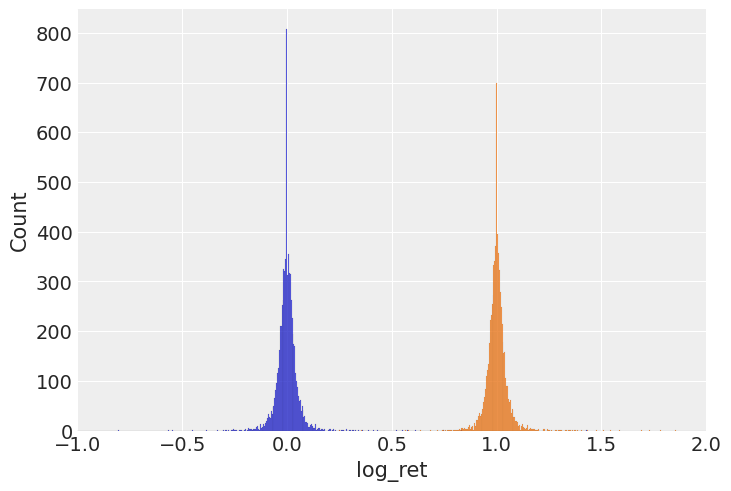

In [33]:
sns.histplot(df_with_features, x="log_ret")
sns.histplot(df_with_features, x="ret")
plt.xlim([-1, 2])

The 3-day lag variance dynamics are plotted below. As we can see the variance has periods of massive volatility.

(0.0, 2.0)

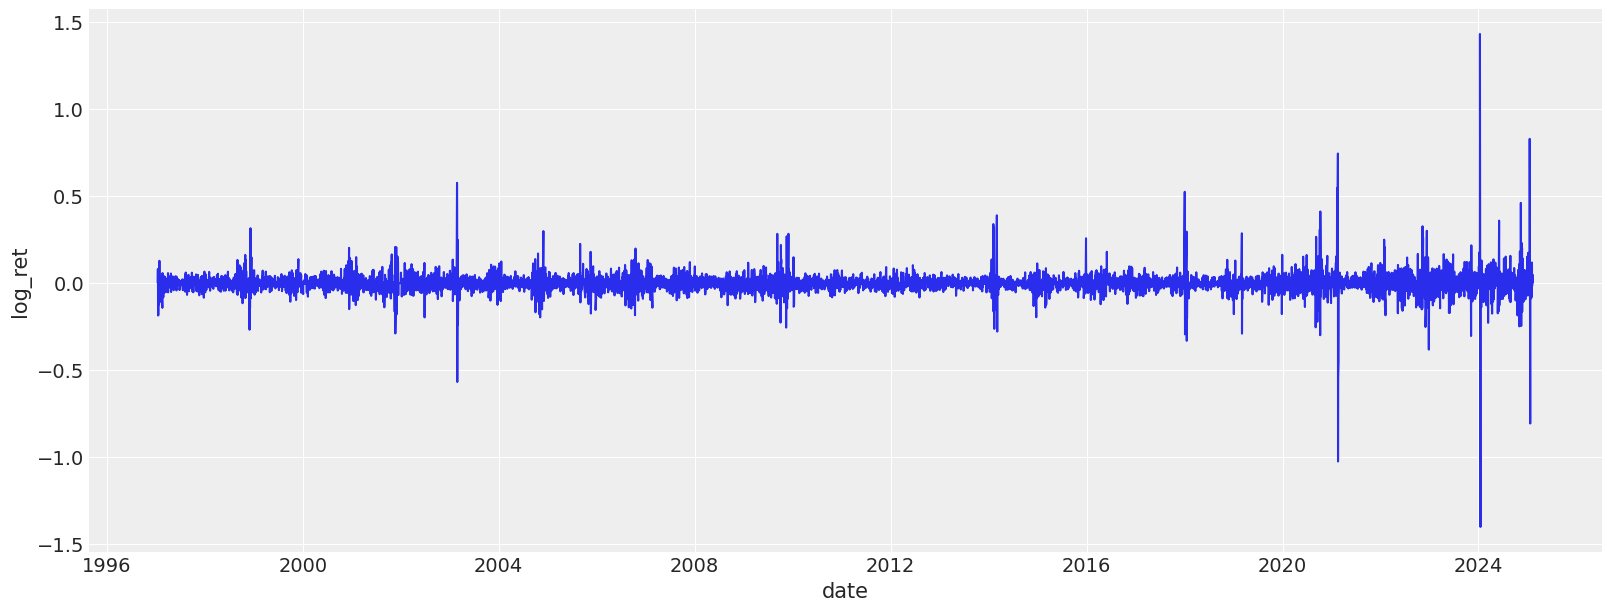

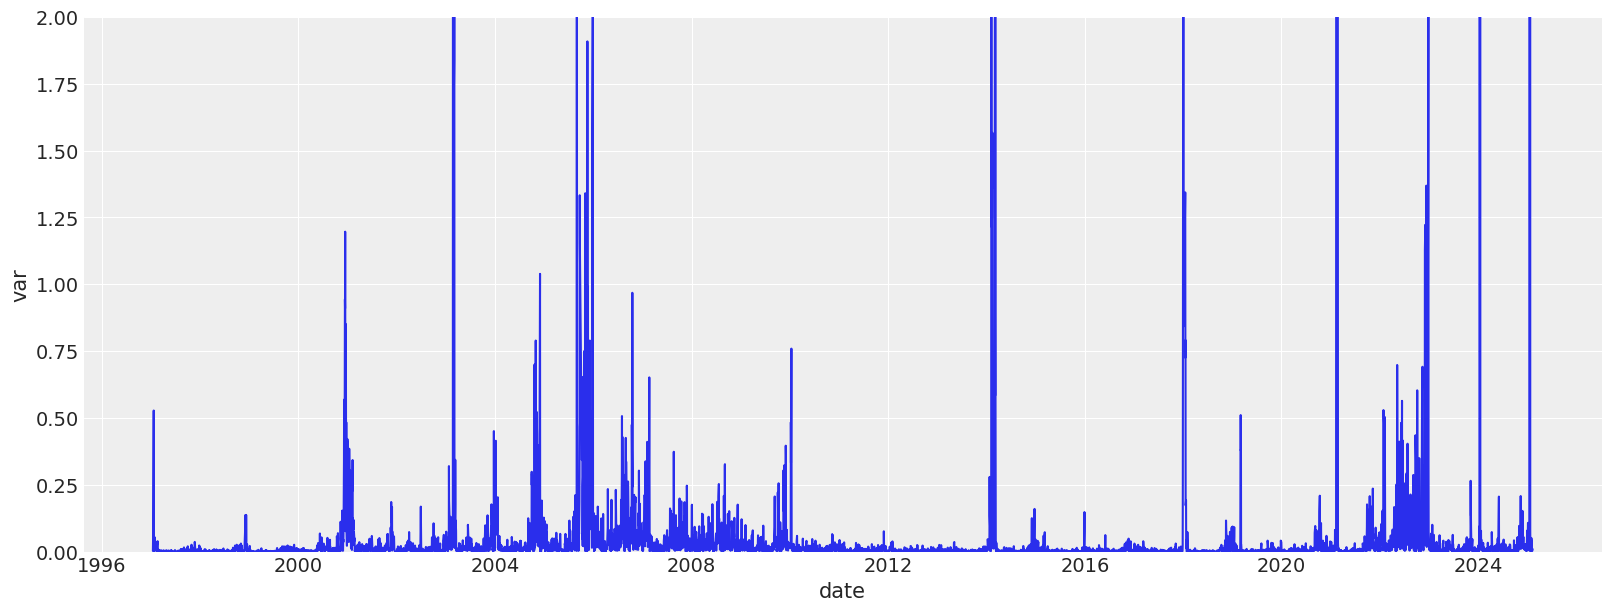

In [34]:
plt.figure(figsize=(16, 6))
sns.lineplot(df_with_features, x="date", y="log_ret")
plt.figure(figsize=(16, 6))
sns.lineplot(df_with_features, x="date", y="var")
plt.ylim(0, 2)

## The model

I decided to go for the following process of modelling the log returns:

$$
\begin{align*}
\log r_t &\sim \mathcal{N}(\mu_t, \sigma_t^2) \\
\mu_t &= \alpha_0 + \sum_{i=1}^S \alpha_i \log r_{t-i} \\
\sigma_t^2 &= \beta_0 + \sum_{i=1}^S \beta_i \sigma_{t-i}^2
\end{align*}
$$

While this model does not properly model the variance the way a ARCH/GARCH model would, I’m going to roll with it anyway for the sake of the learning exercise. It is also worth mentioning that there is a conceptual gap between me using the dataset variance for learning and later generating variance myself and essentially continuing in an autoregressive manner. While true, it's practically a workable approach and used widely in other fields of ML, e.g. trajectory prediction with generative models. One of the next things I'm intending to do is to consider volatility to be latent variable and sample it myself, conditioning the site on observed volatility at the time. When it is not observed, it will just be sampled during the generative phase.

In [35]:
# Cut-off point
T = 300
present_value_train, present_value_test = (
    df_with_features["log_ret"][:-T].to_numpy(),
    df_with_features["log_ret"][-T:].to_numpy(),
)
past_values_train, past_values_test = (
    feature_engineer.to_numpy_dict(df_with_features[:-T]),
    feature_engineer.to_numpy_dict(df_with_features[-T:]),
)

In [36]:
# | export
def garch_like_model(
    present_value: npt.NDArray, past_values: dict[str, npt.NDArray]
) -> None:
    b = numpyro.sample("b", dist.Normal(0, 0.2))
    b_var = numpyro.sample("b_var", dist.Exponential(10))  # So it is positive

    coeffs = {}
    for col, s in feature_engineer.get_iterator("log_ret"):
        param_name = feature_engineer.get_shift_pattern(col, s)
        coeffs[param_name] = numpyro.sample(
            f"param_{param_name}", dist.Normal(0.0, 0.5)
        )

    for col, s in feature_engineer.get_iterator("var"):
        param_name = feature_engineer.get_shift_pattern(col, s)
        coeffs[param_name] = numpyro.sample(f"param_{param_name}", dist.Exponential(10))

    # Handle prediction case
    len_observations = len(present_value) if present_value is not None else 1

    with numpyro.plate("data", len_observations):
        mu = b
        for col, s in feature_engineer.get_iterator("log_ret"):
            param_name = feature_engineer.get_shift_pattern(col, s)
            mu += coeffs[param_name] * past_values[param_name]

        mu_var = b_var
        for col, s in feature_engineer.get_iterator("var"):
            param_name = feature_engineer.get_shift_pattern(col, s)
            mu_var += coeffs[param_name] * past_values[param_name]
        # Condition on observed values if provided
        numpyro.sample("log_ret", dist.Normal(mu, jnp.sqrt(mu_var)), obs=present_value)

Here’s a visualization of the model structure to clarify the dependencies.

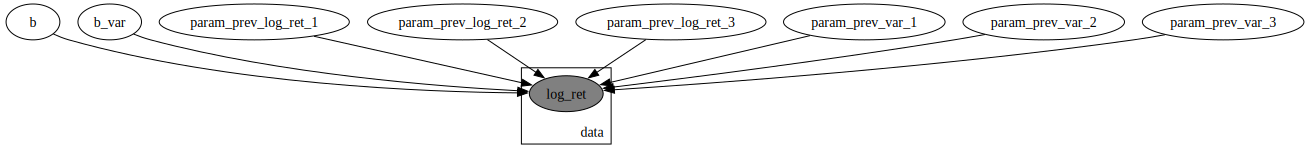

In [37]:
numpyro.render_model(
    garch_like_model,
    model_args=(
        present_value_train,
        past_values_train,
    ),
)

The model if fitted using MCMC with the NUTS sampler.

In [38]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(garch_like_model)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)

mcmc.run(
    rng_key_,
    present_value=present_value_train,
    past_values=past_values_train,
)
mcmc.print_summary()

posterior_samples = mcmc.get_samples()
idata = az.from_numpyro(mcmc)

sample: 100%|██████████| 3000/3000 [00:06<00:00, 460.35it/s, 31 steps of size 1.47e-01. acc. prob=0.94]



                            mean       std    median      5.0%     95.0%     n_eff     r_hat
                     b      0.00      0.00      0.00     -0.00      0.00   1865.07      1.00
                 b_var      0.00      0.00      0.00      0.00      0.00   1569.63      1.00
  param_prev_log_ret_1      0.03      0.01      0.03      0.01      0.06   1658.50      1.00
  param_prev_log_ret_2     -0.10      0.01     -0.10     -0.12     -0.07   1957.84      1.00
  param_prev_log_ret_3     -0.03      0.01     -0.03     -0.06     -0.01   1554.26      1.00
      param_prev_var_1      0.04      0.00      0.04      0.03      0.04   1454.73      1.00
      param_prev_var_2      0.00      0.00      0.00      0.00      0.00   1970.33      1.00
      param_prev_var_3      0.02      0.00      0.02      0.02      0.02   1565.87      1.00

Number of divergences: 0


The model seems to be converging well(notice the $\hat{r}$), let us now explore basic diagnostics for the model. Starting with the forest plot of the posterior. I can immediately notice two interesting things: both biases for log return and variance are 0. Also, all variance terms except for the previous one are essentially 0 too, meaning that only the variance of the previous 3 days is important. We might very well have selected a bad time frame and we need to experiment with shorter/longer variance aggregation time frames. There is a need to study volatility clustering patterns somehow.

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

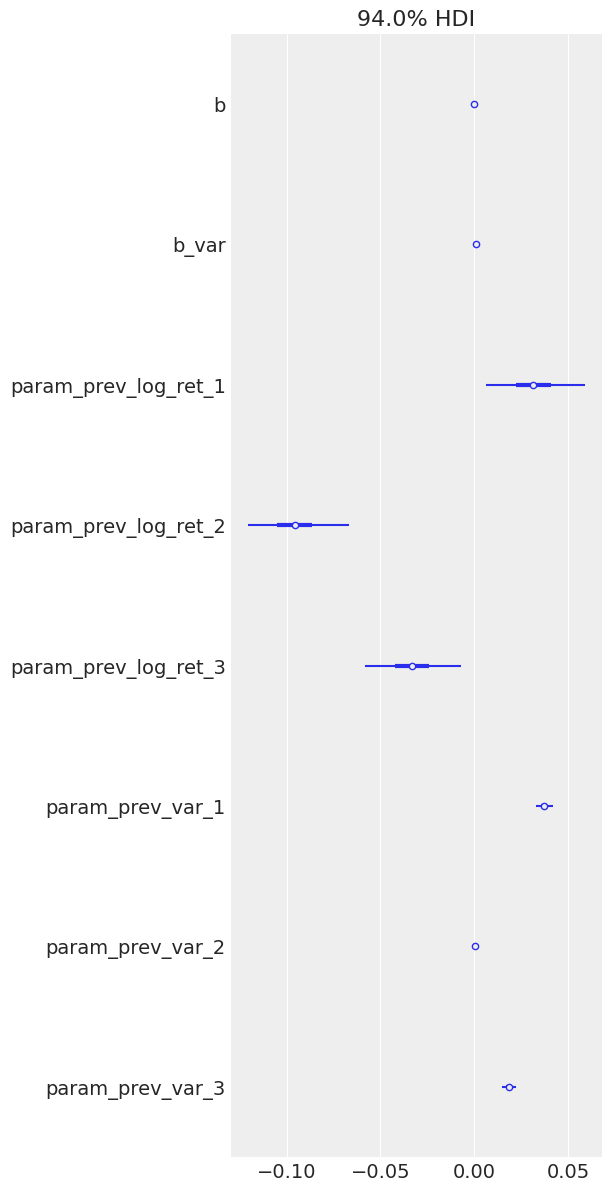

In [39]:
az.plot_forest(posterior_samples)

Let's plot the HMC chains too, which all look adequate and as if sampling happens with high efficiency. The only odd chain is for the second lag of the variance, but that coefficient is estimated to be 0, which is consistent with higher order lags, so it seems like it can be safely ignored. 

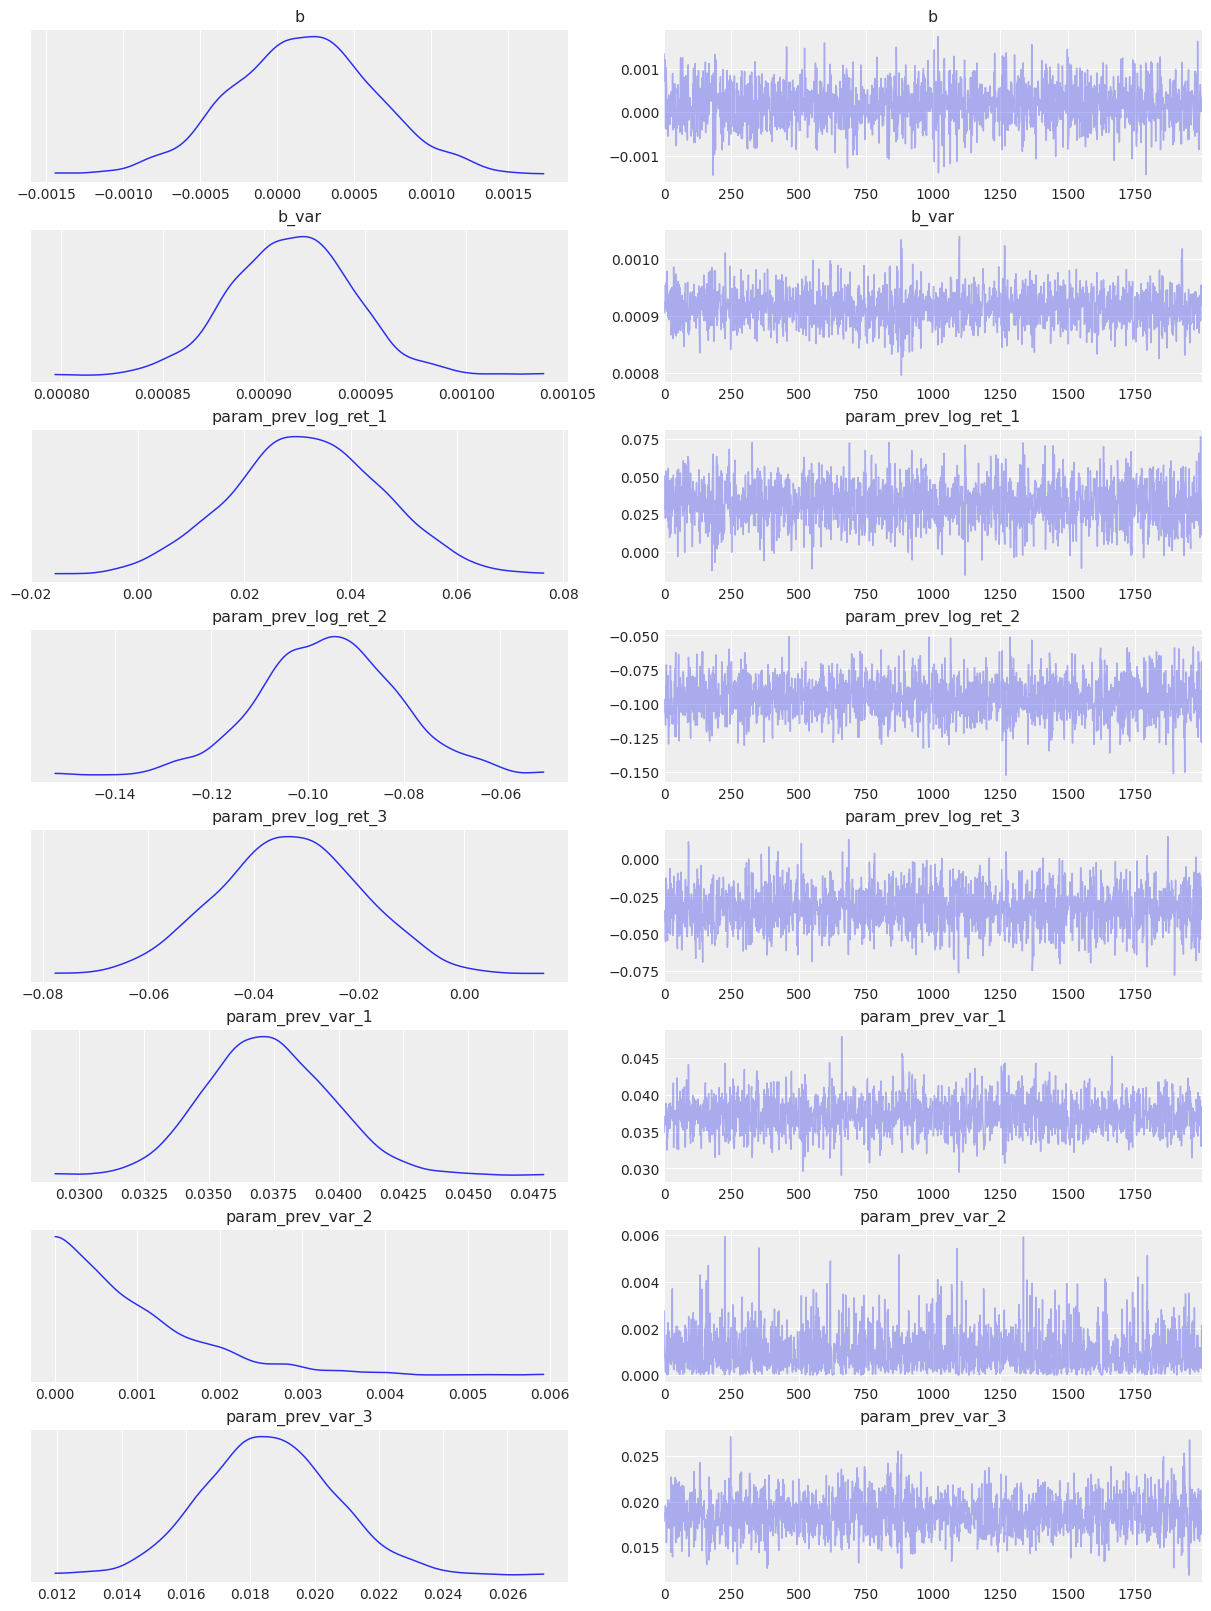

In [40]:
az.plot_trace(idata);

Let's now implement the autoregressive part of the model. Starting from the last known price and update the model. All needed components, such as the predicted log returns that will be used as past values, as well as the variance that will be used autoregressively as well.

In [41]:
def append_from_log_ret(df: pl.DataFrame, new_log_ret: float) -> pl.DataFrame:
    """Adds a new record to the dataframe based on a log return value.

    Args:
        df: Input DataFrame containing time series data
        new_log_ret: The new log return value to add

    Returns:
        DataFrame with a new row appended
    """
    # Get the latest date and add one day
    last_date = df["date"].max()
    new_date = last_date + timedelta(days=1)

    # Calculate the new return value from log return
    new_ret = np.exp(new_log_ret)

    # Get the last price and calculate the new price
    last_price = df["price"].tail(1).item()
    new_price = last_price * new_ret

    # Create a new row
    new_row = pl.DataFrame(
        {
            "date": [new_date],
            "price": [new_price],
            "ret": [new_ret],
        }
    )

    # Append the new row to the existing DataFrame
    return pl.concat([df, new_row])

Finally ready to generate some paths for the natural gas prices. This is a simple autoregressive loop wherein the newly generated data is fed as input into the next step.

In [42]:
num_sims = 1000
all_trajectories = []

# We want a single sample when going through the auto-regressive part
posterior_for_gen = {k: ps[0:1] for k, ps in posterior_samples.items()}
target_site = "log_ret"

# Generate some randomness for sampling
rng_key = random.PRNGKey(1)
rng_key, sim_key = random.split(rng_key)
for sim_id in tqdm(range(num_sims)):
    sim_key, traj_key = random.split(sim_key)

    # Create the predictive object to actually sample log returns
    prior_predictive = Predictive(
        garch_like_model,
        posterior_samples=posterior_for_gen,
        num_samples=1,
    )

    # Init the starting price and the features
    starting_sim_df = source_df[-T - feature_engineer.n_shifts * 5 - 50 : -T]
    feature_sim_df = feature_engineer.create_features(starting_sim_df)
    current_price_shifts = feature_engineer.to_numpy_dict(feature_sim_df[-1])
    for t in range(min(T, 30)):
        # Obtain prior predictions
        traj_key, step_key = random.split(traj_key)
        prior_predictions = prior_predictive(
            step_key,
            present_value=None,
            past_values=current_price_shifts,
        )
        # Takes any samples from the site and record it
        new_log_ret = prior_predictions[target_site].squeeze().item()
        starting_sim_df = append_from_log_ret(starting_sim_df, new_log_ret=new_log_ret)

        # With the new record attached, we re-extract the features.
        feature_sim_df = feature_engineer.create_features(starting_sim_df)
        current_price_shifts = feature_engineer.to_numpy_dict(feature_sim_df[-1])
    all_trajectories.append(starting_sim_df.with_columns(run_id=pl.lit(sim_id)))
all_runs = pl.concat(all_trajectories)


100%|██████████| 1000/1000 [00:49<00:00, 20.16it/s]


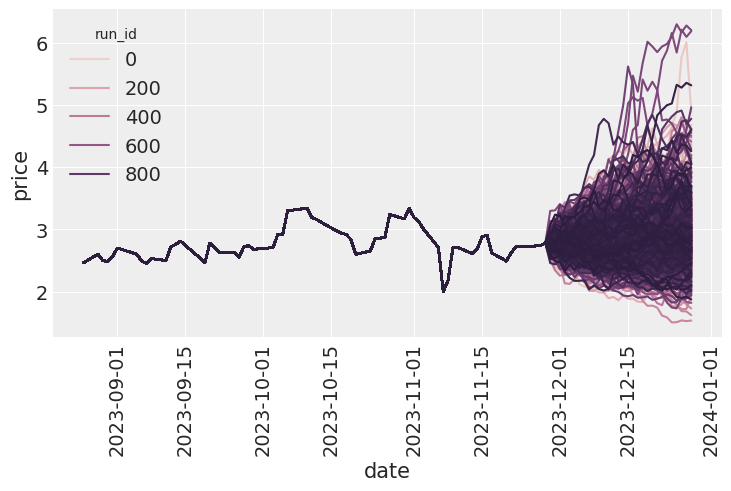

In [43]:
sns.lineplot(all_runs, x="date", y="price", hue="run_id")
plt.xticks(rotation=90);


As we can see on the charts below, the generated paths exhibit generally adequate behavior. Very few paths deviate and end up too high, and there is no degenerate behaviour with negative prices or prices near 0. While negative prices did happen in 2022 for oil, that is not typical and not something one could reasonably predict.

I now turn my attention to looking at the distribution for the final prices among the generated paths. We can see a somewhat healthy asymmetric distribution with a few high price examples on the right hand side. We can clearly see that the paths generated show there is some reasonable expected price behavior.

<Axes: xlabel='final_price', ylabel='Count'>

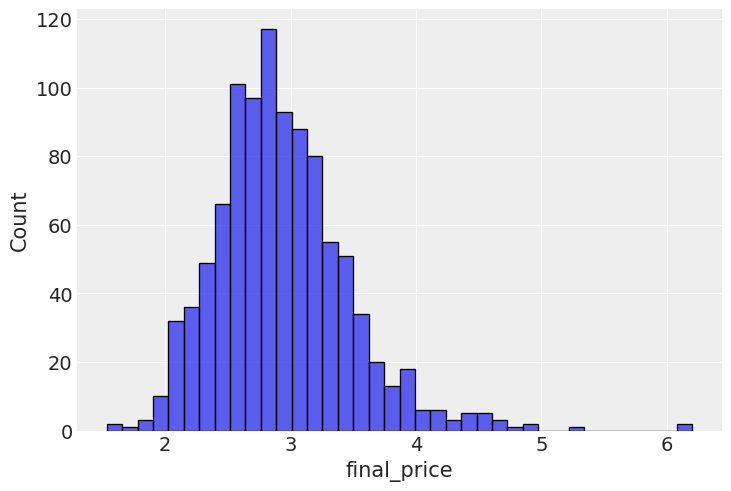

In [44]:
last_prices = (
    all_runs.sort("date")  # Ensure dates are in correct order
    .group_by("run_id")
    .agg(pl.col("price").last())  # Get the last price for each run
    .rename({"price": "final_price"})
)
sns.histplot(last_prices, x="final_price")

Next, we calculate the call option payoff distributions, as well as model-implied option prices.

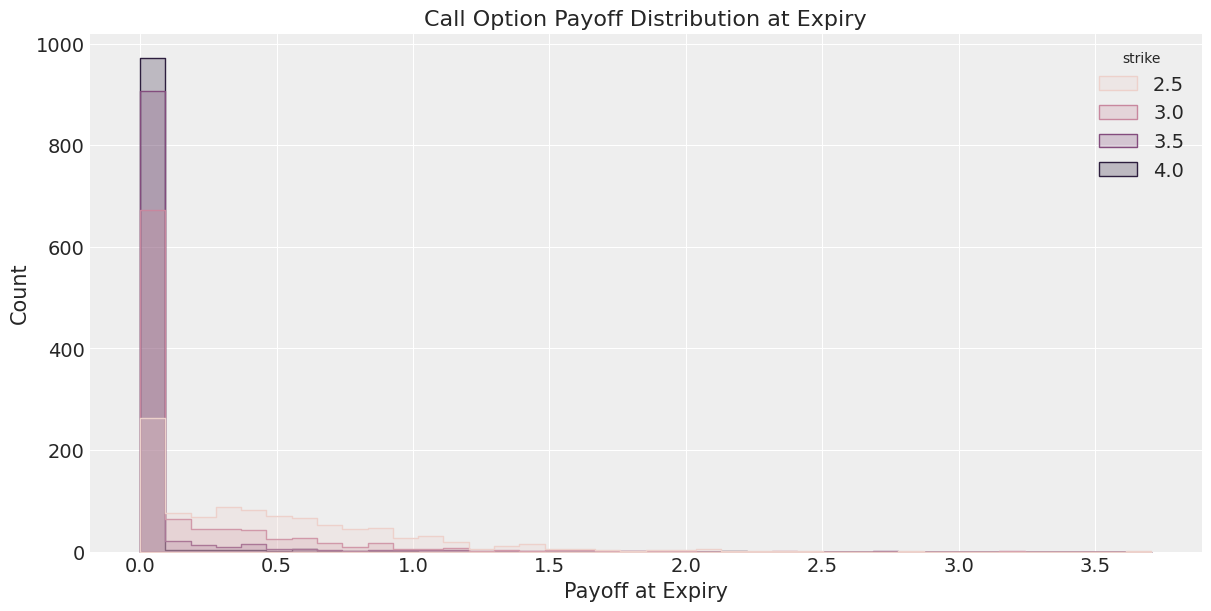

In [45]:
strike_prices = [2.5, 3.0, 3.5, 4.0]

# Create a list of DataFrames, one per strike
payoff_dfs = [
    last_prices.with_columns(
        payoff_at_expiry=(pl.col("final_price") - strike).clip(0),
        strike=pl.lit(strike),  # so we can track which row belongs to which strike
    )
    for strike in strike_prices
]

# Concatenate into one big DataFrame
payoff_df_all = pl.concat(payoff_dfs)
plt.figure(figsize=(12, 6))
sns.histplot(
    data=payoff_df_all,
    x="payoff_at_expiry",
    hue="strike",
    element="step",
    stat="count",
    bins=40,
)
plt.title("Call Option Payoff Distribution at Expiry")
plt.xlabel("Payoff at Expiry")
plt.ylabel("Count")
plt.grid(True)
plt.show()

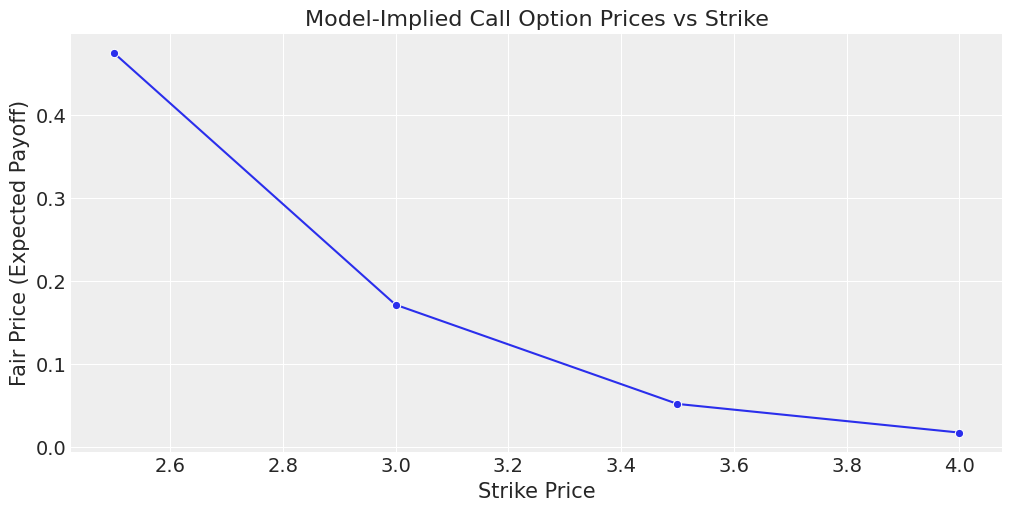

In [46]:
# Group and average payoff per strike
implied_prices = payoff_df_all.group_by("strike").agg(pl.col("payoff_at_expiry").mean())

# Plot the pricing curve
plt.figure(figsize=(10, 5))
sns.lineplot(data=implied_prices, x="strike", y="payoff_at_expiry", marker="o")
plt.title("Model-Implied Call Option Prices vs Strike")
plt.xlabel("Strike Price")
plt.ylabel("Fair Price (Expected Payoff)")
plt.grid(True)
plt.show()

This wraps up my initial attempt at a generative, volatility-aware option pricing framework. There’s more work to be done—especially around incorporating latent volatility, or testing market-implied vol surfaces—but even this simplified model gives useful directional insight. Overall, this project was a small but useful step toward building generative models that respect volatility dynamics, rather than assuming them away. There’s a long road between “reasonable simulations” and “production-grade financial modeling,” but this framework makes experimentation and extension straightforward—and that’s exactly the point.